In [35]:
import math

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.utils.class_weight import compute_class_weight

import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split

from data_manipulation.reading_util import load_non_enz_esm2
from collections import Counter
from data_manipulation.reading_util import load_all_sub_classes
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score

load_dotenv()


True

![Image of Split30](/home/malte/Desktop/Dataset/plots/class_count_comparison/SPLIT30.png)

In [36]:
emb_path = os.getenv("ESM2_ENZYMES_SPLIT_30")
csv_path = os.getenv("CSV30_ENZYMES")



non_enzymes_esm2_path = os.getenv("ESM2_NON_ENZYMES")
non_enzymes_fasta_path = os.getenv("FASTA_NON_ENZYMES")


# Extracting 2nd ec class form wanted main class
----

### Critical 2nd ec classes

| Class | Count |
|-------|-------|
| 1.10  | 10    |
| 1.20  | 8     |
| 1.23  | 2     |
| 1.97  | 7     |
| 2.2   | 19    |
| 2.9   | 5     | 
| 2.10  | 2     |
| 3.3   | 18    |
| 3.7   | 14    |
| 3.8   | 8     |
| 3.9   | 1     |
| 3.11  | 1     |
| 3.13  | 1     |
| 4.5   | 1     |
| 4.7   | 1     |
| 5.5   | 18    |
| 5.99  | 1     |
| 6.4   | 11    |
| 6.6   | 6     |
| 7.3   | 9     |
| 7.4   | 9     |
| 7.5   | 4     |
| 7.6   | 13    |
  
----


In [37]:
# all possible sub classes in split 30
ec_to_label = {
    "1.1": 0,
    "1.2": 1,
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 18,
    "1.23": 19,
    "1.97": 20,
    "2.1": 21,
    "2.3": 22,
    "2.4": 23,
    "2.5": 24,
    "2.6": 25,
    "2.7": 26,
    "2.8": 27,
    "2.2": 28,
    "2.9": 29,
   "2.10": 30,
    "3.1": 31,
    "3.2": 32,
    "3.4": 33,
    "3.5": 34,
    "3.6": 35,
    "3.3": 36,
    "3.7": 37,
    "3.8": 38,
    "3.9": 39,
   "3.11": 40,
   "3.13": 41,
    "4.1": 42,
    "4.2": 43,
    "4.3": 44,
    "4.4": 45,
    "4.6": 46,
   "4.99": 47,
    "4.7": 48,
    "4.5": 49,
    "5.1": 50,
    "5.2": 51,
    "5.3": 52,
    "5.4": 53,
    "5.5": 54,
    "5.6": 55,
    "5.7": 56,
   "5.99": 57,
    "6.1": 58,
    "6.2": 59,
    "6.3": 60,
    "6.5": 61,
    "6.4": 62,
    "6.6": 63,
    "7.1": 64,
    "7.2": 65,
    "7.3": 66,
    "7.4": 67,
    "7.5": 68,
    "7.6": 69,
}

# Compressed 2nd subclasses when # samples in subclass < 20
comp_ec_to_label = { 
    "1.1": 0,
    "1.2": 1, 
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 17,
    "1.23": 17,
    "1.97": 17,
    "2.1": 18,
    "2.3": 19,
    "2.4": 20,
    "2.5": 21,
    "2.6": 22,
    "2.7": 23,
    "2.8": 24,
    "2.2": 25,
    "2.9": 25,
    "2.10": 25,
    "3.1": 26,
    "3.2": 27,
    "3.4": 28,
    "3.5": 29,
    "3.6": 30,
    "3.3": 31,
    "3.7": 31,
    "3.8": 31,
    "3.9": 31,
    "3.11": 31,
    "3.13": 31,
    "4.1": 32,
    "4.2": 33,
    "4.3": 34,
    "4.4": 35,
    "4.6": 36,
    "4.99": 37,
    "4.7": 37,
    "4.5": 37,
    "5.1": 38,
    "5.2": 39,
    "5.3": 40,
    "5.4": 41,
    "5.5": 42,
    "5.6": 43,
    "5.7": 43,
    "5.99": 43,
    "6.1": 44,
    "6.2": 45,
    "6.3": 46,
    "6.5": 47,
    "6.4": 47,
    "6.6": 47,
    "7.1": 48,
    "7.2": 49,
    "7.3": 50,
    "7.4": 50,
    "7.5": 50,
    "7.6": 50,
}


comp_label_to_ec = {
 0: "1.1" ,
 1: "1.2" ,
 2: "1.3" ,
 3: "1.4" ,
 4: "1.5" ,
 5: "1.6" ,
 6: "1.7" ,
 7: "1.8" ,
 8: "1.11" ,
 9: "1.12" ,
 10: "1.13" ,
 11: "1.14" ,
 12: "1.15" ,
 13: "1.16" ,
 14: "1.17" ,
 15: "1.18" ,
 16: "1.21" ,
 17: "1.10|20|23|97" ,
 18: "2.1" ,
 19: "2.3" ,
 20: "2.4" ,
 21: "2.5" ,
 22: "2.6" ,
 23: "2.7" ,
 24: "2.8" ,
 25: "2.2|9|19" ,
 26: "3.1" ,
 27: "3.2" ,
 28: "3.4" ,
 29: "3.5" ,
 30: "3.6" ,
 31: "3.3|7|8|9|11|13" ,
 32: "4.1" ,
 33: "4.2" ,
 34: "4.3" ,
 35: "4.4" ,
 36: "4.6" ,
 37: "4.99|7|5" ,
 38: "5.1" ,
 39: "5.2" ,
 40: "5.3" ,
 41: "5.4" ,
 42: "5.5" ,
 43: "5.6|7|99" ,
 44: "6.1" ,
 45: "6.2" ,
 46: "6.3" ,
 47: "6.5|4|6" ,
 48: "7.1" ,
 49: "7.2" ,
 50: "7.3|4|5|6" ,
}



comp_ec_to_label_non_ez = {
    "1.1": 0,
    "1.2": 1,
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 17,
    "1.23": 17,
    "1.97": 17,
    "2.1": 18,
    "2.3": 19,
    "2.4": 20,
    "2.5": 21,
    "2.6": 22,
    "2.7": 23,
    "2.8": 24,
    "2.2": 25,
    "2.9": 25,
    "2.10": 25,
    "3.1": 26,
    "3.2": 27,
    "3.4": 28,
    "3.5": 29,
    "3.6": 30,
    "3.3": 31,
    "3.7": 31,
    "3.8": 31,
    "3.9": 31,
    "3.11": 31,
    "3.13": 31,
    "4.1": 32,
    "4.2": 33,
    "4.3": 34,
    "4.4": 35,
    "4.6": 36,
    "4.99": 37,
    "4.7": 37,
    "4.5": 37,
    "5.1": 38,
    "5.2": 39,
    "5.3": 40,
    "5.4": 41,
    "5.5": 42,
    "5.6": 43,
    "5.7": 43,
    "5.99": 43,
    "6.1": 44,
    "6.2": 45,
    "6.3": 46,
    "6.5": 47,
    "6.4": 47,
    "6.6": 47,
    "7.1": 48,
    "7.2": 49,
    "7.3": 50,
    "7.4": 50,
    "7.5": 50,
    "7.6": 50,
    "Non enzyme":51
}


comp_label_to_ec_non_ez = {
    0: "1.1" ,
    1: "1.2" ,
    2: "1.3" ,
    3: "1.4" ,
    4: "1.5" ,
    5: "1.6" ,
    6: "1.7" ,
    7: "1.8" ,
    8: "1.11" ,
    9: "1.12" ,
    10: "1.13" ,
    11: "1.14" ,
    12: "1.15" ,
    13: "1.16" ,
    14: "1.17" ,
    15: "1.18" ,
    16: "1.21" ,
    17: "1.10|20|23|97" ,
    18: "2.1" ,
    19: "2.3" ,
    20: "2.4" ,
    21: "2.5" ,
    22: "2.6" ,
    23: "2.7" ,
    24: "2.8" ,
    25: "2.2|9|19" ,
    26: "3.1" ,
    27: "3.2" ,
    28: "3.4" ,
    29: "3.5" ,
    30: "3.6" ,
    31: "3.3|7|8|9|11|13" ,
    32: "4.1" ,
    33: "4.2" ,
    34: "4.3" ,
    35: "4.4" ,
    36: "4.6" ,
    37: "4.99|7|5" ,
    38: "5.1" ,
    39: "5.2" ,
    40: "5.3" ,
    41: "5.4" ,
    42: "5.5" ,
    43: "5.6|7|99" ,
    44: "6.1" ,
    45: "6.2" ,
    46: "6.3" ,
    47: "6.5|4|6" ,
    48: "7.1" ,
    49: "7.2" ,
    50: "7.3|4|5|6" ,
    51: "Non enzyme"
}



In [38]:
print(len(comp_ec_to_label))
print(len(ec_to_label))

70
70


In [39]:
X, y, label_to_ec = load_all_sub_classes(emb_path, csv_path, allowed_labels=comp_ec_to_label)


X_non_enzymes, y_non_enzymes = load_non_enz_esm2(non_enzymes_fasta_path=non_enzymes_fasta_path,
                                                 non_enzymes_esm2_path=non_enzymes_esm2_path)



LOG:
 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 203 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 221 entries will be ignored


KeyboardInterrupt: 

In [11]:

X_non_enzymes = X_non_enzymes[:1000]
del y_non_enzymes

y_non_enzymes = np.array([51 for _ in X_non_enzymes])

In [12]:

X = np.vstack((X, X_non_enzymes))
y = np.hstack((y, y_non_enzymes))


In [40]:

X, y, label_to_ec = load_all_sub_classes(emb_path, csv_path, allowed_labels=comp_ec_to_label)


LOG:
 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 203 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 221 entries will be ignored
LOG:
 Data loaded in: 1.029 min
LOG:
 ESM2 of enzymes: 9204
LOG:
 Labels of enzymes: 9204


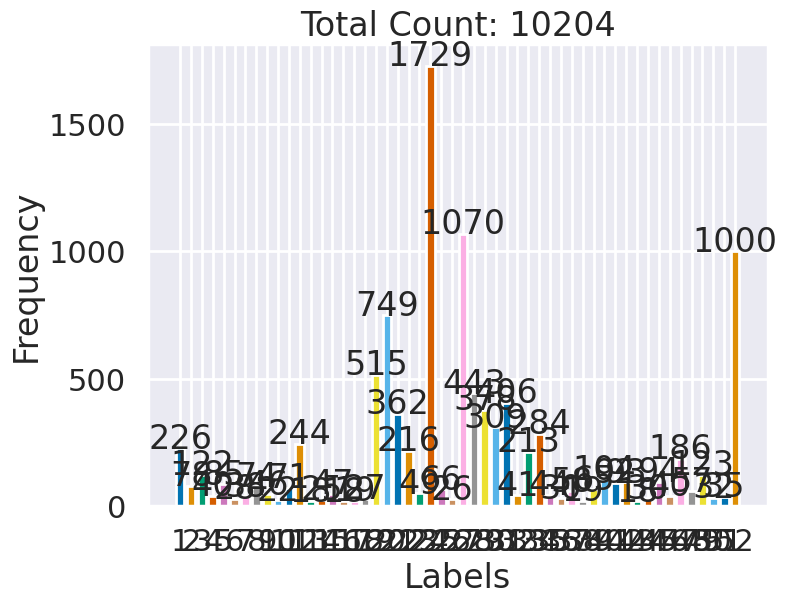

In [8]:

sns.set()
sns.set_palette("colorblind")
sns.set("poster", style="darkgrid")

y_enzymes = np.array([y+1 for y in y])
unique, counts = np.unique(y_enzymes, return_counts=True)

# Using the colorblind palette for colors
colors = sns.color_palette("colorblind")

# Creating the bar plot with assigned colors
plt.figure(figsize=(8, 6))
bars = plt.bar(unique, counts, tick_label=unique, color=colors)

# Adding count labels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 0.1, str(count), ha='center')

# Total count of all classes
total_count = np.sum(counts)
plt.title(f'Total Count: {total_count}')

plt.xlabel('Labels')
plt.ylabel('Frequency')

plt.show()


In [41]:
# y_encoded = tf.keras.utils.to_categorical(y, num_classes=len(label_to_ec))

# oversample = SMOTE()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# X_train_dup = np.vstack((X_train, X_train))
# y_train_dup = np.hstack((y_train, y_train))

# y_train_dup_encoded = tf.keras.utils.to_categorical(y_train_dup, num_classes=len(label_to_ec))

# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(comp_label_to_ec))
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(comp_label_to_ec))

file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/y_train_subclass_lables.txt"
np.savetxt(file_path, y_train, delimiter=',', fmt='%d')

In [6]:

def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro'), "Micro F1-Score"


In [10]:
print(len(X_train))
print(len(y_train))

7142
7142


In [14]:
print(max(y))

51


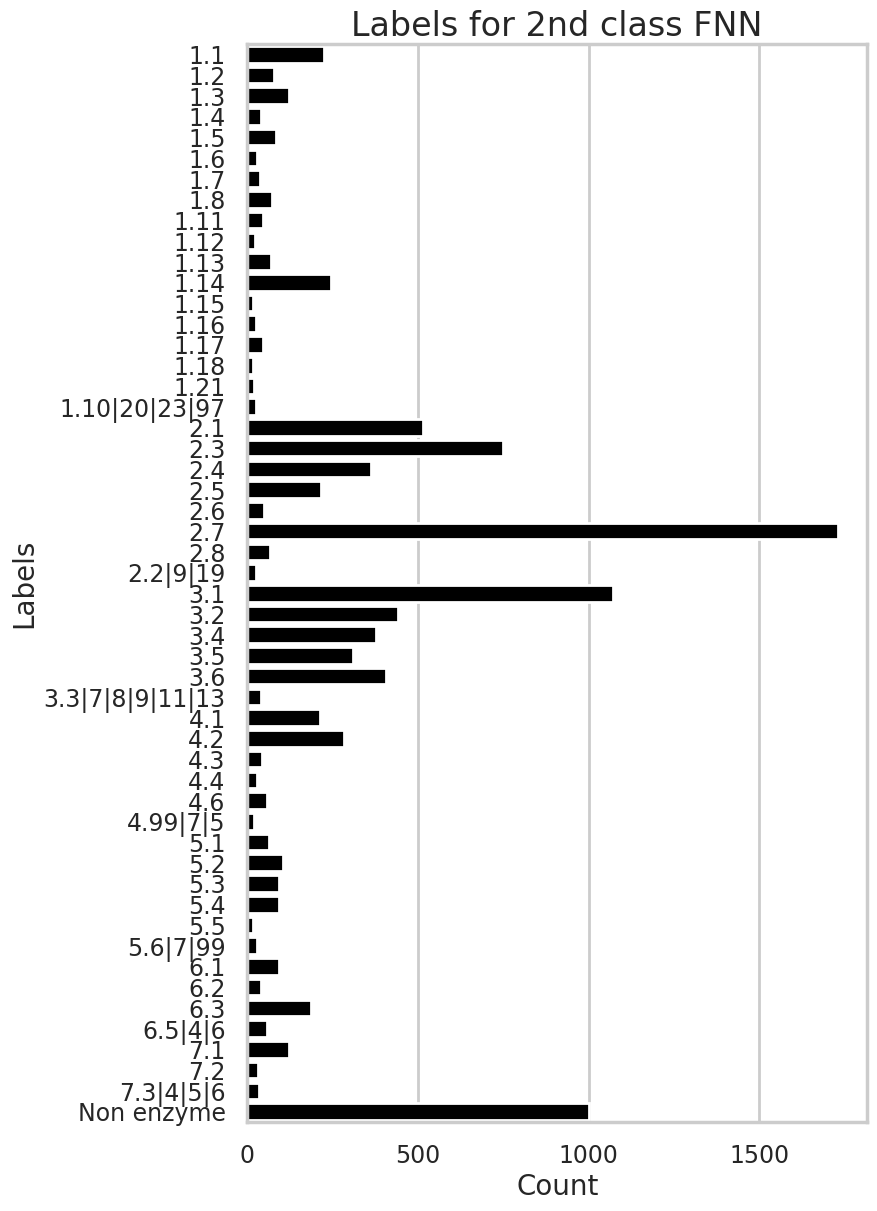

In [11]:
y_sorted = y.copy()
y_sorted.sort()

sns.set_style("whitegrid")
y_ec_classes = [comp_label_to_ec_non_ez[label] for label in y_sorted]
plt.figure(figsize=(8, 14))  # Adjust the figure size if needed
sns.set_style("whitegrid")

countplot = sns.countplot(y=y_ec_classes, color="black")

# Add labels and title
plt.title("Labels for 2nd class FNN", fontsize=24)
plt.ylabel("Labels", fontsize=20)
plt.xlabel("Count", fontsize=20)

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)


# Show the plot
plt.show()

# Training a CNN based on amount of y_labels
----

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
# y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(sec_to_label))
# y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(sec_to_label))


# y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_ec))
# y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(label_to_ec))



In [11]:
print(y_test_encoded[0])
print(len(X_train))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
12885


# Optimizing with Optuna
----

In [44]:
def objective(trial):
    # Define hyperparameters to be optimized
    num_units_dense_1 = trial.suggest_int('num_units_dense_1', 32, 512)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.7)
    num_units_dense_2 = trial.suggest_int('num_units_dense_2', 16, 128)

    # Create the model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_units_dense_1, activation='relu', input_shape=(2560,)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Dense(units=num_units_dense_2, activation='relu'))
    
    model.add(tf.keras.layers.Dense(units=len(comp_label_to_ec), activation='softmax'))

    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Split your data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Convert class weights to a dictionary
    class_weight_dict = dict(enumerate(class_weights))

    y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(comp_label_to_ec))
    y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=len(comp_label_to_ec))

    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10)

    # Train the model
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=40, callbacks=[early_stop], verbose=0, class_weight=class_weight_dict)

    # Get the best validation loss
    val_loss = min(history.history['val_loss'])

    return val_loss


In [45]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)  # You can adjust the number of trials as needed

[I 2023-12-10 19:54:59,107] A new study created in memory with name: no-name-622c3cfa-1ea5-4ec8-b1bc-1caa20fd0c4d
[I 2023-12-10 19:56:38,895] Trial 0 finished with value: 1.0979255437850952 and parameters: {'num_units_dense_1': 355, 'dropout_rate_1': 0.3208018172296341, 'num_units_dense_2': 71}. Best is trial 0 with value: 1.0979255437850952.
[I 2023-12-10 19:58:32,366] Trial 1 finished with value: 1.1754436492919922 and parameters: {'num_units_dense_1': 407, 'dropout_rate_1': 0.6226231820436037, 'num_units_dense_2': 67}. Best is trial 0 with value: 1.0979255437850952.
[I 2023-12-10 19:59:15,123] Trial 2 finished with value: 1.1443034410476685 and parameters: {'num_units_dense_1': 139, 'dropout_rate_1': 0.44885608108902175, 'num_units_dense_2': 48}. Best is trial 0 with value: 1.0979255437850952.
[I 2023-12-10 20:00:31,128] Trial 3 finished with value: 1.067063808441162 and parameters: {'num_units_dense_1': 297, 'dropout_rate_1': 0.25759588785761617, 'num_units_dense_2': 111}. Best is 

KeyboardInterrupt: 

In [46]:
# with weighted classes
# best_params = {'num_units_dense_1': 386, 'dropout_rate_1': 0.22389168924519676, 'num_units_dense_2': 180, 'dropout_rate_2': 0.5276690456556323, 'num_units_dense_3': 100}

# v3 best
# best_params = study.best_params
# best_params = {'num_units_dense_1': 457, 'dropout_rate_1': 0.6740827127867876, 'num_units_dense_2': 149, 'dropout_rate_2': 0.1578959816342327, 'num_units_dense_3': 182}

# v1 best params
# best_params = {'num_units_dense_1': 386, 'dropout_rate_1': 0.4179955867912854, 'num_units_dense_2': 187, 'dropout_rate_2': 0.28289383930137707, 'num_units_dense_3': 54} 


# with non ez
#best_params = study.best_params
best_params ={'num_units_dense_1': 257, 'dropout_rate_1': 0.231752121019741, 'num_units_dense_2': 128} 
best_num_units_dense_1 = best_params['num_units_dense_1']
best_dropout_rate_1 = best_params['dropout_rate_1']
best_num_units_dense_2 = best_params['num_units_dense_2']

best_params = {'num_units_dense_1': 507, 'dropout_rate_1': 0.21784049956965024, 'num_units_dense_2': 106}
best_num_units_dense_1 = best_params['num_units_dense_1']
best_dropout_rate_1 = best_params['dropout_rate_1']
best_num_units_dense_2 = best_params['num_units_dense_2']


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# prev b
# best_num_units_dense_1 = 482
# best_dropout_rate_1 = 0.6974068495461625
# best_num_units_dense_2 = 277
# best_dropout_rate_2 = 0.04421161571807377
# best_num_units_dense_3 = 127

# v4 {'num_units_dense_1': 457, 'dropout_rate_1': 0.6740827127867876, 'num_units_dense_2': 149, 'dropout_rate_2': 0.1578959816342327, 'num_units_dense_3': 182}

final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_1, activation='relu', input_shape=(2560,)))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_1))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_2, activation='relu'))

final_model.add(tf.keras.layers.Dense(units=len(comp_label_to_ec), activation='softmax'))
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=15)

final_model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=250, callbacks=[early_stop], verbose=1, class_weight=class_weight_dict)


Epoch 1/250
202/202 [==============================] - 4s 20ms/step - loss: 3.8687 - accuracy: 0.0734 - val_loss: 3.6788 - val_accuracy: 0.1137
Epoch 2/250
202/202 [==============================] - 4s 20ms/step - loss: 3.1626 - accuracy: 0.1881 - val_loss: 2.8870 - val_accuracy: 0.2947
Epoch 3/250
202/202 [==============================] - 4s 20ms/step - loss: 2.3076 - accuracy: 0.3219 - val_loss: 2.5375 - val_accuracy: 0.3458
Epoch 4/250
202/202 [==============================] - 4s 20ms/step - loss: 1.7466 - accuracy: 0.4295 - val_loss: 1.9563 - val_accuracy: 0.5047
Epoch 5/250
202/202 [==============================] - 4s 20ms/step - loss: 1.3763 - accuracy: 0.5104 - val_loss: 1.8974 - val_accuracy: 0.5272
Epoch 6/250
202/202 [==============================] - 4s 20ms/step - loss: 1.1133 - accuracy: 0.5782 - val_loss: 1.7980 - val_accuracy: 0.5395
Epoch 7/250
202/202 [==============================] - 4s 20ms/step - loss: 0.9281 - accuracy: 0.6312 - val_loss: 1.6800 - val_accuracy:

In [11]:
# Initializing the model
# model = tf.keras.models.Sequential()
# 
# earl_stop = tf.keras.callbacks.EarlyStopping(patience=3)
# 
# # Adding input layer
# model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))
# 
# # Adding hidden layer
# model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
# model.add(tf.keras.layers.Dense(units=128, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
# model.add(tf.keras.layers.Dense(units=64, activation='relu'))
# 
# # Finally adding output layer using softmax as activation function
# model.add(tf.keras.layers.Dense(units=len(sec_to_label), activation='softmax'))  # Using softmax for multi-class classification
# 
# Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam')


In [12]:
# model.fit(x=X_train, y=y_train_encoded, epochs=30, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

<Figure size 1000x600 with 0 Axes>

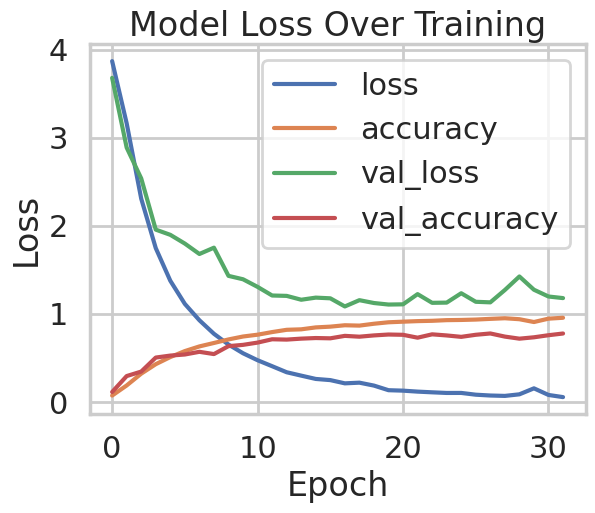

In [47]:
model_loss = pd.DataFrame(final_model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [48]:
predictions = np.argmax(final_model.predict(X_test), axis=-1) 

87/87 [==============================] - 0s 3ms/step


In [49]:
tf.keras.models.save_model(final_model, "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/1012_enz_only_FNN_1.keras")



In [50]:

model = tf.keras.models.load_model("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/1012_enz_only_FNN_1.keras")

predictions = np.argmax(model.predict(X_test), axis=-1) 

87/87 [==============================] - 0s 3ms/step


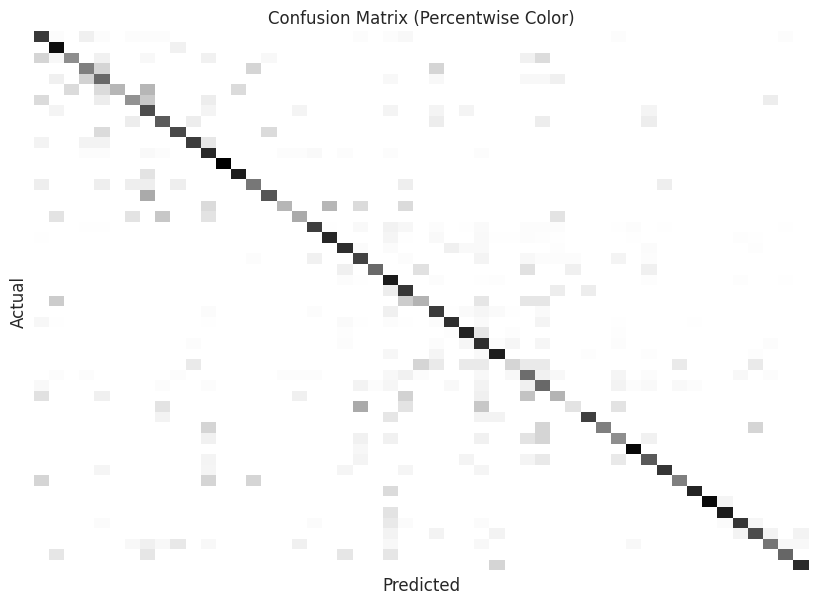

In [51]:
class_labels = list(comp_label_to_ec.values())

conf_matrix = confusion_matrix(y_test, predictions)
row_sums = conf_matrix.sum(axis=1)
conf_matrix_percent = (conf_matrix.T / row_sums).T * 100

# Create a confusion matrix heatmap
plt.figure(figsize=(10, 7))

# Plot the heatmap with percentwise coloring
heatmap = sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="binary", cbar=False)

# Remove x and y tick labels
heatmap.set_xticks([])
heatmap.set_yticks([])

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

plt.title("Confusion Matrix (Percentwise Color)", fontsize=12)
plt.show()

# Validation

In [54]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

model = tf.keras.models.load_model("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/1012_enz_only_FNN_1.keras")

emb_path = os.getenv("TEST_ESM2_ENZYMES")
csv_path = os.getenv("TEST_CSV_ENZYMES")


fasta_path = os.getenv("TEST_FASTA_NON_ENZYMES")
emb_non_ez_path = os.getenv("TEST_ESM2_NON_ENZYMES")

X, y, label_to_ec = load_all_sub_classes(emb_path, csv_path, allowed_labels=comp_ec_to_label_non_ez)

# X_non_enzymes, _ = load_non_enz_esm2(non_enzymes_fasta_path=fasta_path,
#                                      non_enzymes_esm2_path=emb_non_ez_path)
# 
# del _
# 
# y_non_enzymes = np.array([51 for _ in range(len(X_non_enzymes))])
# 
# 
# X = np.vstack((X, X_non_enzymes))
# y = np.hstack((y, y_non_enzymes))



predictions = np.argmax(model.predict(X), axis=-1)

counter = 0
total = 0
print(y)
for t, p in zip(y, predictions):
    total += 1
    if t == p:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", total)



LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/Test_Data/all.csv
LOG:
 0 Sequences with aa U in /home/malte/Desktop/Dataset/Test_Data/all.csv
LOG:
 4 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/Test_Data/all.csv
LOG:
 4 entries will be ignored
LOG:
 Data loaded in: 0.069 min
LOG:
 ESM2 of enzymes: 578
LOG:
 Labels of enzymes: 578
19/19 [==============================] - 0s 3ms/step
[ 0 21 20 20 20 21  0 11 34 30 33 11 41  1  1  8 19 19 33 18  0 33 33 33
 11 18 18 28 32 23 19 21 21  2  2 23 40 19 11 11 33 32 33 21  0 23 34 34
  8  8  0  0 11  1 19 27 21 10  2  4 18  0 11 33  0 33 33  0  8 11 11 23
  0 23 19 23 23 26 23 23 23 19 33  0 19  1 23 23 21 19 21  1  0  0 11 11
  0  1 33 33 33 11  1 33 11 23  0 11 26 20 29  0 33 19 23 23 41 19 23 11
 38 11 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33  0 26 33 23 33 33 11
 27 33 33 20 20  1 18 46 33 33 33 33 33 33 33 33 11 11  2 11 11 19 23 11
  2 19 19 40 23  2 32 11 46 33 33 33 46 19 11 11 10 33 

In [55]:

print(classification_report(y, predictions))


              precision    recall  f1-score   support

           0       0.93      0.67      0.78        63
           1       1.00      0.95      0.97        19
           2       0.86      0.96      0.91        25
           3       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         0
           8       1.00      0.25      0.40         4
           9       0.00      0.00      0.00         0
          10       0.56      0.83      0.67         6
          11       1.00      1.00      1.00        53
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.90      0.96      0.93        27
          19       0.92      0.96      0.94        25
          20       0.90      0.75      0.82        12
          21       0.93    

/home/malte/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/malte/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/malte/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/malte/.local/lib/python3.10/site-packages/

/tmp/ipykernel_70510/1053383385.py:5: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percent = (conf_matrix.T / row_sums).T * 100


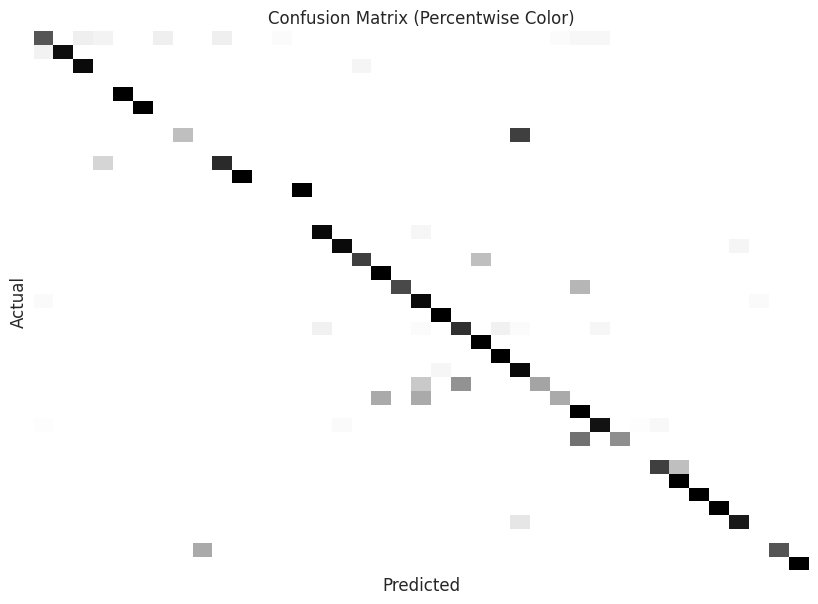

In [56]:
class_labels = list(comp_label_to_ec.values())

conf_matrix = confusion_matrix(y, predictions)
row_sums = conf_matrix.sum(axis=1)
conf_matrix_percent = (conf_matrix.T / row_sums).T * 100

# Create a confusion matrix heatmap
plt.figure(figsize=(10, 7))

# Plot the heatmap with percentwise coloring
heatmap = sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="binary", cbar=False)

# Remove x and y tick labels
heatmap.set_xticks([])
heatmap.set_yticks([])

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

plt.title("Confusion Matrix (Percentwise Color)", fontsize=12)
plt.show()


# Calculate standard error

         Model             Metric  Mean Score     SE      CI_0      CI_1
0  FNN Level 2  Weighted F1-Score        0.87  0.014  0.845296  0.901507
1  FNN Level 2     Macro F1-Score        0.68  0.037  0.613995  0.754189
2  FNN Level 2     Micro F1-Score        0.87  0.014  0.840830  0.896194
3  FNN Level 2           Accuracy        0.87  0.014  0.840830  0.896194


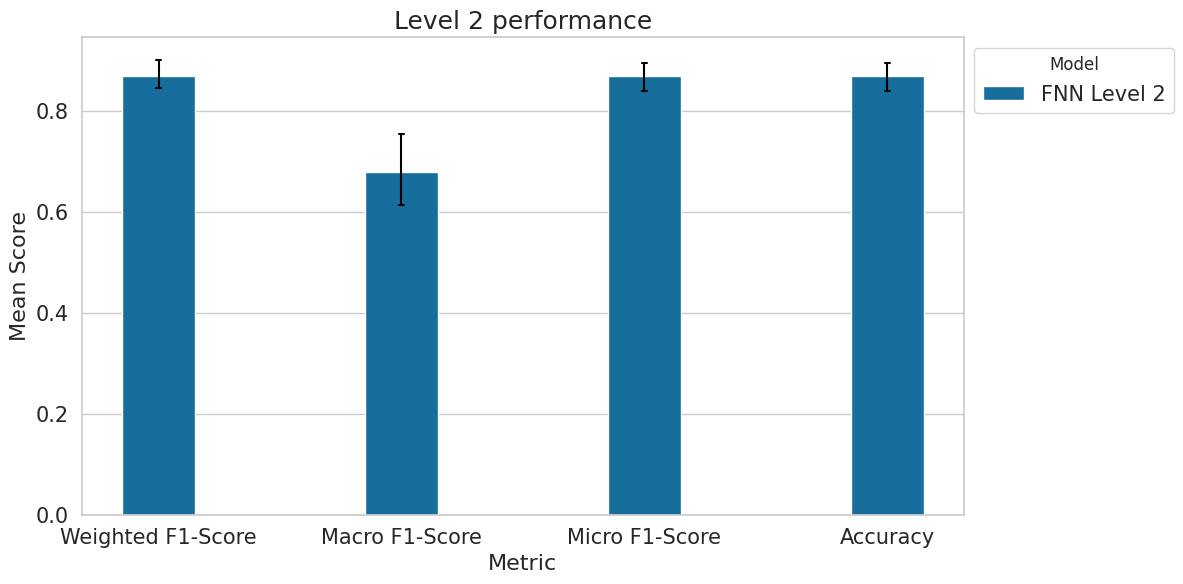

In [57]:

from metrics_helper_funcs.validation_tools import plot_bootstrapped_score, plot_confiusion_matrix, calculate_micro_f1, calculate_accuracy, calculate_macro_f1, calculate_weighted_f1


plot_bootstrapped_score(y_trues=[y], y_preds=[predictions], scoring_funcs=[calculate_weighted_f1, calculate_macro_f1, calculate_micro_f1, calculate_accuracy], model_names=["FNN Level 2"], plot_title="Level 2 performance")


/home/malte/01_Documents/projects/pbl_binary_classifier/metrics_helper_funcs/validation_tools.py:27: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percent = (conf_matrix.T / row_sums).T * 100


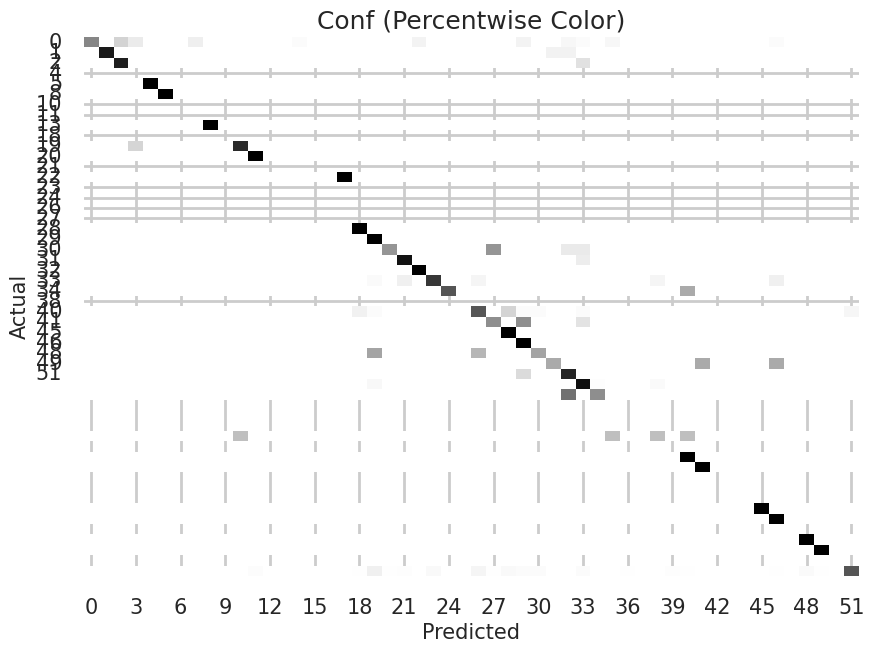

In [34]:

plot_confiusion_matrix(y, predictions, "Conf", hide_inner_labels=True)


# Checking FNNs predicted values in main classes

In [40]:

y_val_main_class_labels = [int(comp_label_to_ec[label].split(".")[0]) for label in y]
y_pred_main_class_labels = [int(comp_label_to_ec[label].split(".")[0]) for label in predictions]

# Convert the lists to NumPy arrays
y_val_main_class_labels = np.array(y_val_main_class_labels)
y_pred_main_class_labels = np.array(y_pred_main_class_labels)


print(y_val_main_class_labels)
print(y_pred_main_class_labels)


[1 2 2 2 2 2 1 1 4 3 4 1 5 1 1 1 2 2 4 2 1 4 4 4 1 2 2 3 4 2 2 2 2 1 1 2 5
 2 1 1 4 4 4 2 1 2 4 4 1 1 1 1 1 1 2 3 2 1 1 1 2 1 1 4 1 4 4 1 1 1 1 2 1 2
 2 2 2 3 2 2 2 2 4 1 2 1 2 2 2 2 2 1 1 1 1 1 1 1 4 4 4 1 1 4 1 2 1 1 3 2 3
 1 4 2 2 2 5 2 2 1 5 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 3 4 2 4 4 1 3 4 4 2
 2 1 2 6 4 4 4 4 4 4 4 4 1 1 1 1 1 2 2 1 1 2 2 5 2 1 4 1 6 4 4 4 6 2 1 1 1
 4 2 3 5 4 2 1 1 1 1 2 1 1 5 1 2 4 1 4 2 6 1 2 2 2 2 3 2 7 3 3 3 3 3 2 3 3
 3 3 1 2 3 3 2 3 1 6 1 2 3 3 1 2 7 7 1 3 3 4 6 2 3 1 7 3 3 1 2 2 2 3 3 3 1
 1 2 2 2 3 1 1 2 3 1 3 4 1 4 3 3 2 2 2 3 2 5 1 1 2 5 4 2 5 2 1 2 1 3 3 1 2
 4 3 3 2 3 3 1 3 1 1 1 3 3 3 4 2 3 3 4 3 2 3 3 3 2 2 3 1 1 3 3 3 3 3 3 3 3
 3 4 3 3 3 2 3 1 2 4 1 1 2 2 3 3 2 4 3 3 3 4 4 2 2 1 4 3 1 1 1 1 2 2 1 2 3
 2 3 1 1 1 1 1 1 2 2 1 3 4 1 2 2 2 2 2 2 2 2 3 3 2 3 3 2 3 3 2 2 2 3 4 1 1
 2 3 3 2 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 1 1 1 1 1 1 1 2 2 2 4
 3 3 3 2 2 2 6 1 1 2 6 2 1 3 1 1 1 3 4 3 1 4 1 5 3 2 5 2 2 3 2 2 3 2 2 4 4
 2 6 1 4 5 1 1 1 1 4 5 1 

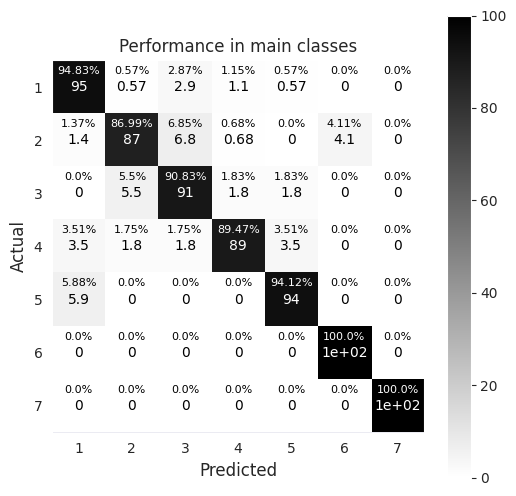

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = [1,2,3,4,5,6,7]
conf_matrix = confusion_matrix(y_val_main_class_labels, y_pred_main_class_labels)
row_sums = conf_matrix.sum(axis=1)
conf_matrix_percent = (conf_matrix.T / row_sums).T * 100

# Calculate the percentages
cm_percentage = (conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]) * 100
cm_percentage = cm_percentage.round(2)

# Create a ConfusionMatrixDisplay without labels
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=class_names)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(cmap="binary", ax=ax)
cax = ax

# Add the percentages as text annotations in the squares with specified ha and va
for i in range(7):
    for j in range(7):

        # Increase the vertical offset for the percentage text
        offset = 0.4
        text_color = cax.texts[i * 7 + j].get_color()
        ax.text(j, i - offset, f'{float(cm_percentage[i, j])}%', ha='center', va='top', color=text_color, fontsize=8, fontweight='light', zorder=4)


# Set the x and y labels
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.grid(False)
plt.title("Performance in main classes")

plt.show()


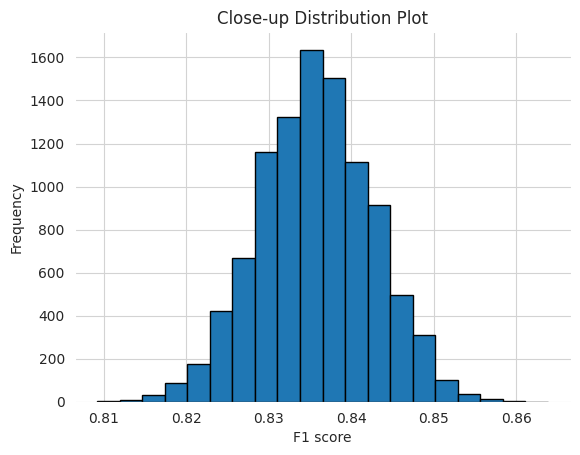

Multiclass CNN:
  - Initial F1 Score: 0.84
  - Mean ± SE: 0.836 ± 0.0069
  - 95% CI: [0.82, 0.85]


In [28]:
initial_f1 = calculate_f1(y_val_main_class_labels, y_pred_main_class_labels)
mean_f1, se_f1, ci_95 = bootstrap_statistic(y_val_main_class_labels, y_pred_main_class_labels, calculate_f1)

rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

print(f"Multiclass CNN:")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - Mean ± SE: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
